## Cải tiến bao gồm:
1. Cải tiến cục bộ (2-opt, 3-opt, Swap) và Hàm heuristic hybrid (mô hình HACO-VRPDP).
2. Chiến lược cập nhật pheromone thông minh hơn (mô hình IACO-VRPDP)
3. Cài đặt giới hạn động lương phernone (Dynamic Pheromone Bounds) (mô hình DACO-VRPDP).


In [21]:
# Thư viện
import numpy as np
import pandas as pd
import random
import ast
import os
import matplotlib.pyplot as plt
from copy import deepcopy


## Load, xử lý dữ liệu và cài đặt tham số dùng chung cho cả 3 mô hình: 
1. Mô hình HACO-VRPDP; 
2. Mô hình IACO-VRPDP
3. Mô hình DACO-VRPDP

In [22]:
# Load, xử lý dữ liệu và cài đặt tham số
# # Load dữ liệu
DATA_PATH = "vrpdp_dataset.csv"
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"The dataset file '{DATA_PATH}' was not found. Please ensure it exists in the working directory.")
df = pd.read_csv(DATA_PATH)

# Xử lý dữ liệu
for col in ['PickupCoord', 'DeliveryCoord', 'PickupTimeWindow', 'DeliveryTimeWindow']:
    df[col] = df[col].apply(ast.literal_eval)

# Tọa độ điểm giao nhận hàng
nodes = [0] + sorted(set(df['PickupNode']).union(df['DeliveryNode']))
coords = {0: (40.0, 50.0)}
for _, row in df.iterrows():
    coords[row['PickupNode']] = row['PickupCoord']
    coords[row['DeliveryNode']] = row['DeliveryCoord']

# Ma hóa tọa độ giao nhận hàng
def distance(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

distance_matrix = np.zeros((len(nodes), len(nodes)))
for i in range(len(nodes)):
    for j in range(len(nodes)):
        if i != j:
            distance_matrix[i][j] = distance(coords[nodes[i]], coords[nodes[j]])

# Thuật ngữ
pickup_nodes = list(df["PickupNode"])
delivery_nodes = list(df["DeliveryNode"])
demands = dict(zip(df["PickupNode"], df["Demand"]))
pickup_windows = dict(zip(df["PickupNode"], df["PickupTimeWindow"]))
delivery_windows = dict(zip(df["DeliveryNode"], df["DeliveryTimeWindow"]))

# Tham số mô hình
num_ants = 10
num_iterations = 20
num_vehicles = 3
alpha = 1.0
beta = 4.0
rho = 0.4
Q_pheromone = 800
vehicle_capacity = 100
pheromone = np.ones_like(distance_matrix)
#pheromone = np.ones((len(nodes), len(nodes)))

# Ý nghĩa các tham số

- alpha         : *pheromone có ảnh hưởng trung bình*
- beta          : *heuristic (khoảng cách) được ưu tiên hơn*
- rho           : *% pheromone sẽ bay hơi sau mỗi vòng*
- Q_pheromone   : *lượng pheromone sẽ rải trên cung tốt nhất*
- num_ants      : *số lượng xe/kiến xây dựng tuyến tối ưu cho mỗi vòng*
- num_iterations: *Số vòng thuật toán chạy tối đa*
- vehicle_capacity:  *tải trọng tối đa của 1 xe*
- num_vehicles  : số lượng xe của 1 depot

## 1. Mô hình HACO-VRPDP: 
- Cải tiến cục bộ (2-opt, 3-opt, Insert và Swap) 
- Hàm heuristic hybrid

In [23]:
# Mô hình HACO-VRPDP
pickup_nodes = list(df["PickupNode"])
delivery_nodes = list(df["DeliveryNode"])
demands = dict(zip(df["PickupNode"], df["Demand"]))
best_solution = None
best_cost = float('inf')
# Penalty functions
def time_window_penalty(node, arrival_time=0):
    if node == 0: return 0
    tw = pickup_windows.get(node, delivery_windows.get(node, (0, float('inf'))))
    return max(0, tw[0] - arrival_time) + max(0, arrival_time - tw[1])

def demand_penalty(node, load):
    if node in demands:
        demand = demands[node]
    else:
        matching = df[df['DeliveryNode'] == node]
        if not matching.empty:
            pickup_node = matching['PickupNode'].values[0]
            demand = -demands[pickup_node]
        else:
            demand = 0
    return max(0, load + demand - vehicle_capacity)

# Local search: 2-opt
def two_opt(route):
    best = route
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route) - 1):
                if j - i == 1: continue
                new_route = route[:i] + route[i:j][::-1] + route[j:]
                if path_cost(new_route) < path_cost(best):
                    best = new_route
                    improved = True
        route = best
    return best

def path_cost(route):
    return sum(distance_matrix[nodes.index(route[i])][nodes.index(route[i+1])] for i in range(len(route)-1))

## Kiểm tra ràng buộc tải trọng cho tuyến xe
def check_load_constraints(route, pickup_to_demand, delivery_to_pickup, vehicle_capacity):
    load = 0
    active_pickups = set()
    used_deliveries = set()
    loads = []

    for idx, node in enumerate(route):
        if node == 0:
            # Depot, reset load (nếu muốn) hoặc giữ nguyên
            loads.append(load)
            continue

        if node in pickup_to_demand:
            demand = pickup_to_demand[node]
            load += demand
            active_pickups.add(node)

        elif node in delivery_to_pickup:
            pickup_node = delivery_to_pickup[node]

            if node in used_deliveries:
                return False, loads, f"Lỗi tại vị trí {idx}: đơn hàng giao {node} đã được giao trước đó"

            if pickup_node not in active_pickups:
                return False, loads, f"Lỗi tại vị trí {idx}: giao hàng {node} trước khi lấy hàng {pickup_node}"

            load -= pickup_to_demand[pickup_node]
            used_deliveries.add(node)

        else:
            return False, loads, f"Lỗi tại vị trí {idx}: node {node} không xác định pickup hay delivery"

        if load < 0:
            return False, loads, f"Lỗi tại vị trí {idx}: tải trọng âm tại node {node} (load={load})"
        if load > vehicle_capacity:
            return False, loads, f"Lỗi tại vị trí {idx}: vượt tải tại node {node} (load={load})"

        loads.append(load)

    return True, loads, "✅ Ràng buộc tải trọng hợp lệ"


# Main HACO-VRPDPloop
for iteration in range(num_iterations):
    for ant in range(num_ants):
        shuffled = list(zip(pickup_nodes, delivery_nodes))
        random.shuffle(shuffled)
        pickup_chunks = [list(x) for x in np.array_split([p for p, _ in shuffled], num_vehicles)]
        delivery_chunks = [list(x) for x in np.array_split([d for _, d in shuffled], num_vehicles)]

        vehicle_routes = [[] for _ in range(num_vehicles)]
        for v in range(num_vehicles):
            route = [0]
            load = 0
            arrival_time = 0
            current_node = 0
            local_pickups = set(pickup_chunks[v])
            local_deliveries = set(delivery_chunks[v])

            while local_pickups or local_deliveries:
                candidates = []
                for j in local_pickups.union(local_deliveries):
                    if j in local_pickups and load + demands[j] <= vehicle_capacity:
                        candidates.append(j)
                    elif j in local_deliveries:
                        pj_match = df[df["DeliveryNode"] == j]
                        if not pj_match.empty:
                            pj = pj_match["PickupNode"].values[0]
                            if pj not in local_pickups:
                                candidates.append(j)

                if not candidates:
                    break

                probs = []
                for j in candidates:
                    i_idx = nodes.index(current_node)
                    j_idx = nodes.index(j)
                    dist = distance_matrix[i_idx][j_idx]

                    if dist < 1e-6:
                        continue

                    time_penalty = time_window_penalty(j, arrival_time + dist)
                    demand_pen = demand_penalty(j, load)
                    denominator = alpha * dist + beta * time_penalty + 0.1 * demand_pen + 1e-6

                    if denominator <= 0 or not np.isfinite(denominator):
                        eta = 1.0
                    else:
                        eta = 1.0 / denominator

                    tau = pheromone[i_idx][j_idx] ** alpha
                    probs.append(tau * eta)

                if not probs or not np.isfinite(sum(probs)) or sum(probs) == 0:
                    break  # hoặc next_node = random.choice(candidates)

                probs = np.array(probs, dtype=np.float64)
                probs /= probs.sum()
                next_node = random.choices(candidates, weights=probs, k=1)[0]

                route.append(next_node)
                arrival_time += distance_matrix[nodes.index(current_node)][nodes.index(next_node)]
                if next_node in demands:
                    load += demands[next_node]
                    local_pickups.discard(next_node)
                else:
                    match = df[df["DeliveryNode"] == next_node]
                    if not match.empty:
                        pickup_node = match["PickupNode"].values[0]
                        load -= demands.get(pickup_node, 0)
                        local_deliveries.discard(next_node)
                current_node = next_node

            
            route.append(0)

            # Kiểm tra ràng buộc tải trọng cho tuyến xe 
            pickup_to_demand = demands
            delivery_to_pickup = dict(zip(df["DeliveryNode"], df["PickupNode"]))
            valid, loads, msg = check_load_constraints(route, pickup_to_demand, delivery_to_pickup, vehicle_capacity)

            if not valid:
                    print(f"[!] Xe {v+1}: {msg}")
                    # Loại bỏ tuyến sai bằng cách gán tuyến chỉ có depot
                    vehicle_routes[v] = [0, 0]
                    continue

            # Nếu hợp lệ, tiếp tục local search
            vehicle_routes[v] = two_opt(route)
        total_cost = sum(path_cost(r) for r in vehicle_routes)

        loads = []
        for r in vehicle_routes:
            load_sum = 0
            for n in r:
                if n == 0:
                    continue
                if n in demands:
                    load_sum += demands[n]
                else:
                    matching = df[df['DeliveryNode'] == n]
                    if not matching.empty:
                        pickup_node = matching['PickupNode'].values[0]
                        load_sum -= demands.get(pickup_node, 0)
            loads.append(load_sum)

        total_cost += 10 * np.std(loads)

        if total_cost < best_cost:
            best_cost = total_cost
            best_solution = vehicle_routes

        delta_pheromone = np.zeros_like(pheromone)
        for route in vehicle_routes:
            for i in range(len(route) - 1):
                a, b = nodes.index(route[i]), nodes.index(route[i+1])
                delta_pheromone[a][b] += Q_pheromone / path_cost(route)

        pheromone *= (1 - rho)
        pheromone += delta_pheromone

# Output
print("Tổng chi phí tối ưu cho cả 3 xe khi chạy mô hình HACO-VRPDP: ", round(best_cost, 2))
for i, route in enumerate(best_solution):
    print(f"\nChi phí tuyến của xe {i+1} khi chạy mô hình HACO-VRPDP:", round(path_cost(route), 2))
    print(f"Tuyến xe {i+1}:", " → ".join(map(str, route)))

Tổng chi phí tối ưu cho cả 3 xe khi chạy mô hình HACO-VRPDP:  734.37

Chi phí tuyến của xe 1 khi chạy mô hình HACO-VRPDP: 237.69
Tuyến xe 1: 0 → 90 → 88 → 77 → 56 → 58 → 45 → 42 → 44 → 29 → 18 → 17 → 12 → 10 → 7 → 0

Chi phí tuyến của xe 2 khi chạy mô hình HACO-VRPDP: 258.02
Tuyến xe 2: 0 → 70 → 75 → 65 → 60 → 59 → 61 → 49 → 36 → 35 → 14 → 100 → 98 → 87 → 89 → 0

Chi phí tuyến của xe 3 khi chạy mô hình HACO-VRPDP: 238.66
Tuyến xe 3: 0 → 24 → 15 → 8 → 76 → 3 → 99 → 84 → 79 → 74 → 78 → 73 → 67 → 47 → 46 → 0


## Visualize các lộ trình 3 xe trong mô hình HACO-VRPDP

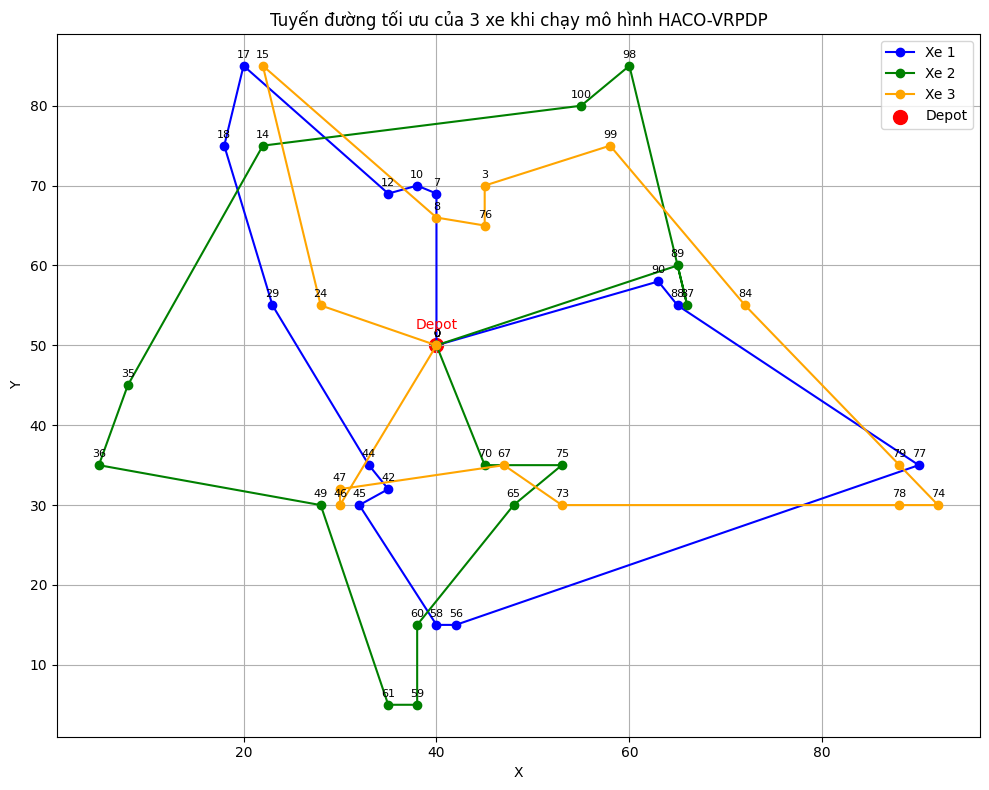

In [24]:

# Vẽ tuyến đường của mỗi xe mô hình HACO-VRPDP
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'purple', 'cyan']
for i, route in enumerate(best_solution):
    x_vals = [coords[n][0] for n in route]
    y_vals = [coords[n][1] for n in route]
    plt.plot(x_vals, y_vals, marker='o', label=f"Xe {i+1}", color=colors[i % len(colors)])
    for n in route:
        plt.text(coords[n][0], coords[n][1]+1, str(n), fontsize=8, ha='center')
plt.scatter(coords[0][0], coords[0][1], color='red', s=100, label='Depot')
plt.text(coords[0][0], coords[0][1]+2, 'Depot', color='red', fontsize=10, ha='center')
plt.title("Tuyến đường tối ưu của 3 xe khi chạy mô hình HACO-VRPDP")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 2. Mô hình IACO-VRPDP: Áp dụng các yếu tố cập nhật pheromone thông minh hơn gồm

1. Global-best update

2. Rank-based update

3. Elitist strategy

4. Pheromone reinforcement có điều kiện

In [25]:
# Xây dựng các hàm: Global-best update; Rank-based update; Elitist strategy; Pheromone reinforcement
# Hàm: Global-best update
def global_best_update(pheromone, best_routes, best_cost, nodes, rho, Q):
    n = len(nodes)
    delta_pheromone = np.zeros((n, n))
    for route in best_routes:
        for i in range(len(route) - 1):
            a, b = nodes.index(route[i]), nodes.index(route[i + 1])
            delta_pheromone[a][b] += Q / best_cost
    pheromone *= (1 - rho)
    pheromone += delta_pheromone
    return pheromone

# Hàm: Rank-based update
def rank_based_update(pheromone, all_routes, all_costs, nodes, rho, Q, w, omega, global_best_route, global_best_cost):
    n = len(nodes)
    delta_pheromone = np.zeros((n, n))
    sorted_routes = [route for _, route in sorted(zip(all_costs, all_routes), key=lambda x: x[0])][:w]
    for r, route in enumerate(sorted_routes):
        for i in range(len(route) - 1):
            a, b = nodes.index(route[i]), nodes.index(route[i + 1])
            delta_pheromone[a][b] += (w - r) * Q / all_costs[r]
    if global_best_route:
        for i in range(len(global_best_route) - 1):
            a, b = nodes.index(global_best_route[i]), nodes.index(global_best_route[i + 1])
            delta_pheromone[a][b] += omega * Q / global_best_cost
    pheromone *= (1 - rho)
    pheromone += delta_pheromone
    return pheromone

# Hàm: Elitist strategy; Pheromone reinforcement
def elitist_update(pheromone, ant_routes, ant_costs, global_best_route, global_best_cost, nodes, rho, Q, e):
    n = len(nodes)
    delta_pheromone = np.zeros((n, n))
    for route, cost in zip(ant_routes, ant_costs):
        for i in range(len(route) - 1):
            a, b = nodes.index(route[i]), nodes.index(route[i + 1])
            delta_pheromone[a][b] += Q / cost
    for i in range(len(global_best_route) - 1):
        a, b = nodes.index(global_best_route[i]), nodes.index(global_best_route[i + 1])
        delta_pheromone[a][b] += e * Q / global_best_cost
    pheromone *= (1 - rho)
    pheromone += delta_pheromone
    return pheromone

# Hàm: Pheromone reinforcement
def conditional_update(pheromone, all_routes, all_costs, best_cost, nodes, rho, Q, delta=0.1):
    """
    Chỉ tăng cường pheromone cho các tuyến có chi phí <= (1 + delta) * best_cost
    """
    n = len(nodes)
    delta_pheromone = np.zeros((n, n))
    threshold = best_cost * (1 + delta)
    for route, cost in zip(all_routes, all_costs):
        if cost <= threshold:
            for i in range(len(route) - 1):
                a, b = nodes.index(route[i]), nodes.index(route[i + 1])
                delta_pheromone[a][b] += Q / cost
    pheromone *= (1 - rho)
    pheromone += delta_pheromone
    return pheromone


## Mô hình IACO-VRPDP

In [26]:
# Mô hình IACO-VRPDP with Multiple Vehicles and Advanced Pheromone Updates
# Penalty functions

def time_window_penalty(node, arrival_time=0):
    if node == 0: return 0
    tw = pickup_windows.get(node, delivery_windows.get(node, (0, float('inf'))))
    return max(0, tw[0] - arrival_time) + max(0, arrival_time - tw[1])

def demand_penalty(node, load):
    if node in demands:
        demand = demands[node]
    else:
        matching = df[df['DeliveryNode'] == node]
        if not matching.empty:
            pickup_node = matching['PickupNode'].values[0]
            demand = -demands[pickup_node]
        else:
            demand = 0
    return max(0, load + demand - vehicle_capacity)

# Local search: 2-opt
def two_opt(route):
    best = route
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route) - 1):
                if j - i == 1: continue
                new_route = route[:i] + route[i:j][::-1] + route[j:]
                if path_cost(new_route) < path_cost(best):
                    best = new_route
                    improved = True
        route = best
    return best

def path_cost(route):
    return sum(distance_matrix[nodes.index(route[i])][nodes.index(route[i+1])] for i in range(len(route)-1))

# --- PHEROMONE UPDATE STRATEGIES ---
def global_best_update(pheromone, best_routes, best_cost, nodes, rho, Q):
    n = len(nodes)
    delta_pheromone = np.zeros((n, n))
    for route in best_routes:
        for i in range(len(route) - 1):
            a, b = nodes.index(route[i]), nodes.index(route[i + 1])
            delta_pheromone[a][b] += Q / best_cost
    pheromone *= (1 - rho)
    pheromone += delta_pheromone
    return pheromone

def rank_based_update(pheromone, all_routes, all_costs, nodes, rho, Q, w, omega, global_best_route, global_best_cost):
    n = len(nodes)
    delta_pheromone = np.zeros((n, n))
    sorted_routes = [route for _, route in sorted(zip(all_costs, all_routes), key=lambda x: x[0])][:w]
    for r, route in enumerate(sorted_routes):
        for i in range(len(route) - 1):
            a, b = nodes.index(route[i]), nodes.index(route[i + 1])
            delta_pheromone[a][b] += (w - r) * Q / all_costs[r]
    if global_best_route:
        for i in range(len(global_best_route) - 1):
            a, b = nodes.index(global_best_route[i]), nodes.index(global_best_route[i + 1])
            delta_pheromone[a][b] += omega * Q / global_best_cost
    pheromone *= (1 - rho)
    pheromone += delta_pheromone
    return pheromone

def elitist_update(pheromone, ant_routes, ant_costs, global_best_route, global_best_cost, nodes, rho, Q, e):
    n = len(nodes)
    delta_pheromone = np.zeros((n, n))
    for route, cost in zip(ant_routes, ant_costs):
        for i in range(len(route) - 1):
            a, b = nodes.index(route[i]), nodes.index(route[i + 1])
            delta_pheromone[a][b] += Q / cost
    for i in range(len(global_best_route) - 1):
        a, b = nodes.index(global_best_route[i]), nodes.index(global_best_route[i + 1])
        delta_pheromone[a][b] += e * Q / global_best_cost
    pheromone *= (1 - rho)
    pheromone += delta_pheromone
    return pheromone

def conditional_update(pheromone, all_routes, all_costs, best_cost, nodes, rho, Q, delta=0.1):
    n = len(nodes)
    delta_pheromone = np.zeros((n, n))
    threshold = best_cost * (1 + delta)
    for route, cost in zip(all_routes, all_costs):
        if cost <= threshold:
            for i in range(len(route) - 1):
                a, b = nodes.index(route[i]), nodes.index(route[i + 1])
                delta_pheromone[a][b] += Q / cost
    pheromone *= (1 - rho)
    pheromone += delta_pheromone
    return pheromone

# Main ACO loop with pheromone update strategy
update_strategies = ["global_best", "rank_based", "elitist", "conditional"]
update_cycle = iter(update_strategies)

global_best_solution = None
global_best_cost = float('inf')

for iteration in range(num_iterations):
    all_routes = []
    all_costs = []

    for ant in range(num_ants):
        shuffled = list(zip(pickup_nodes, delivery_nodes))
        random.shuffle(shuffled)
        pickup_chunks = [list(x) for x in np.array_split([p for p, _ in shuffled], num_vehicles)]
        delivery_chunks = [list(x) for x in np.array_split([d for _, d in shuffled], num_vehicles)]

        vehicle_routes = []
        for v in range(num_vehicles):
            route = [0]
            load = 0
            arrival_time = 0
            current_node = 0
            local_pickups = set(pickup_chunks[v])
            local_deliveries = set(delivery_chunks[v])

            while local_pickups or local_deliveries:
                candidates = []
                for j in local_pickups.union(local_deliveries):
                    if j in local_pickups and load + demands[j] <= vehicle_capacity:
                        candidates.append(j)
                    elif j in local_deliveries:
                        pj_match = df[df["DeliveryNode"] == j]
                        if not pj_match.empty:
                            pj = pj_match["PickupNode"].values[0]
                            if pj not in local_pickups:
                                candidates.append(j)

                if not candidates:
                    break

                probs = []
                for j in candidates:
                    i_idx = nodes.index(current_node)
                    j_idx = nodes.index(j)
                    dist = distance_matrix[i_idx][j_idx]
                    eta = 1.0 / (alpha * dist + beta * time_window_penalty(j, arrival_time + dist) + 0.1 * demand_penalty(j, load) + 1e-6)
                    tau = pheromone[i_idx][j_idx] ** alpha
                    probs.append(tau * eta)

                probs = np.array(probs)
                probs /= probs.sum()
                next_node = random.choices(candidates, weights=probs, k=1)[0]

                route.append(next_node)
                arrival_time += distance_matrix[nodes.index(current_node)][nodes.index(next_node)]
                if next_node in demands:
                    load += demands[next_node]
                    local_pickups.discard(next_node)
                else:
                    match = df[df["DeliveryNode"] == next_node]
                    if not match.empty:
                        pickup_node = match["PickupNode"].values[0]
                        load -= demands.get(pickup_node, 0)
                        local_deliveries.discard(next_node)
                current_node = next_node

            route.append(0)
            route = two_opt(route)
            vehicle_routes.append(route)

        total_cost = sum(path_cost(r) for r in vehicle_routes)
        loads = []
        for r in vehicle_routes:
            load_sum = 0
            for n in r:
                if n == 0: continue
                if n in demands:
                    load_sum += demands[n]
                else:
                    match = df[df['DeliveryNode'] == n]
                    if not match.empty:
                        pickup_node = match['PickupNode'].values[0]
                        load_sum -= demands.get(pickup_node, 0)
            loads.append(load_sum)

        total_cost += 10 * np.std(loads)

        all_routes.extend(vehicle_routes)
        all_costs.extend([path_cost(r) for r in vehicle_routes])

        if total_cost < global_best_cost:
            global_best_cost = total_cost
            global_best_solution = deepcopy(vehicle_routes)

    try:
        strategy = next(update_cycle)
    except StopIteration:
        update_cycle = iter(update_strategies)
        strategy = next(update_cycle)

    if strategy == "global_best":
        pheromone = global_best_update(pheromone, global_best_solution, global_best_cost, nodes, rho, Q_pheromone)
    elif strategy == "rank_based":
        pheromone = rank_based_update(pheromone, all_routes, all_costs, nodes, rho, Q_pheromone, w=5, omega=2, global_best_route=sum(global_best_solution, []), global_best_cost=global_best_cost)
    elif strategy == "elitist":
        pheromone = elitist_update(pheromone, all_routes, all_costs, sum(global_best_solution, []), global_best_cost, nodes, rho, Q_pheromone, e=5)
    elif strategy == "conditional":
        pheromone = conditional_update(pheromone, all_routes, all_costs, global_best_cost, nodes, rho, Q_pheromone, delta=0.1)

# Output
print("Tổng chi phí tối ưu cho cả 3 xe khi chạy mô hình IACO-VRPDP: ", round(global_best_cost, 2))
for i, route in enumerate(global_best_solution):
    print(f"\nChi phí tuyến của xe {i+1} khi chạy mô hình IACO-VRPDP:", round(path_cost(route), 2))
    print(f"Tuyến xe {i+1}:", " → ".join(map(str, route)))

Tổng chi phí tối ưu cho cả 3 xe khi chạy mô hình IACO-VRPDP:  709.48

Chi phí tuyến của xe 1 khi chạy mô hình IACO-VRPDP: 252.88
Tuyến xe 1: 0 → 24 → 70 → 67 → 65 → 60 → 73 → 75 → 78 → 74 → 87 → 99 → 100 → 98 → 89 → 0

Chi phí tuyến của xe 2 khi chạy mô hình IACO-VRPDP: 243.85
Tuyến xe 2: 0 → 42 → 56 → 58 → 46 → 29 → 18 → 12 → 7 → 3 → 90 → 88 → 84 → 79 → 77 → 0

Chi phí tuyến của xe 3 khi chạy mô hình IACO-VRPDP: 212.75
Tuyến xe 3: 0 → 76 → 8 → 10 → 15 → 17 → 14 → 35 → 36 → 49 → 47 → 44 → 45 → 59 → 61 → 0


## Visualize các lộ trình 3 xe trong mô hình IACO-VRPDP

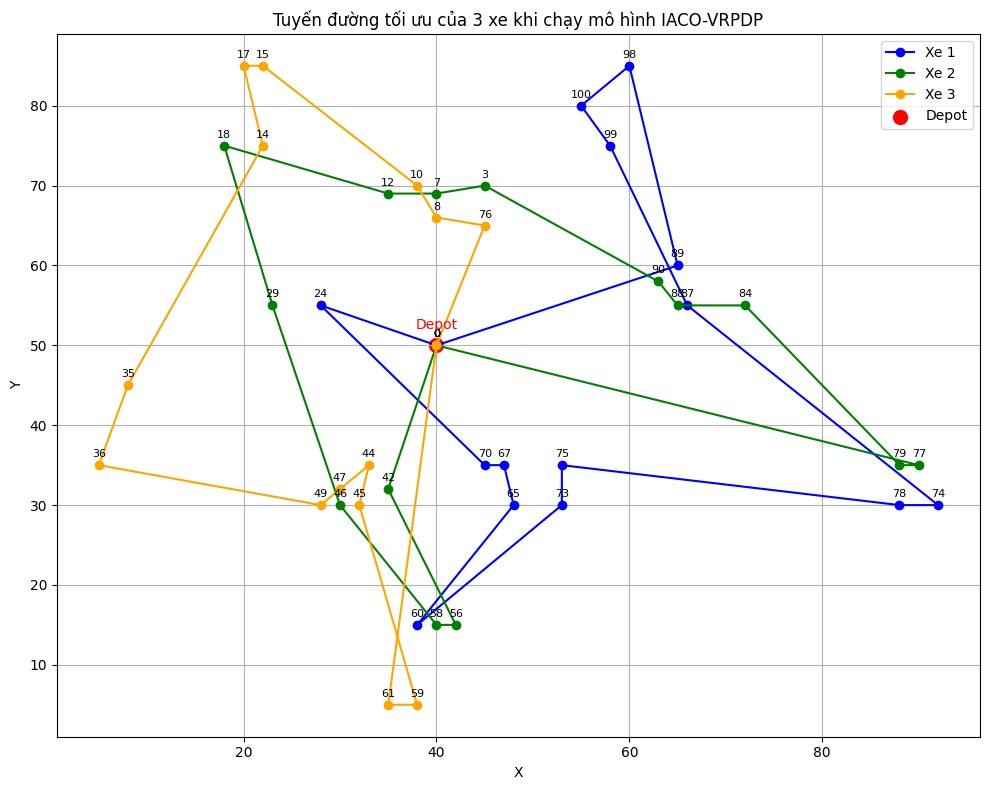

In [27]:
# Vẽ tuyến đường của mỗi xe mô hình IACO-VRPDP
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'purple', 'cyan']
for i, route in enumerate(global_best_solution):
    x_vals = [coords[n][0] for n in route]
    y_vals = [coords[n][1] for n in route]
    plt.plot(x_vals, y_vals, marker='o', label=f"Xe {i+1}", color=colors[i % len(colors)])
    for n in route:
        plt.text(coords[n][0], coords[n][1]+1, str(n), fontsize=8, ha='center')
plt.scatter(coords[0][0], coords[0][1], color='red', s=100, label='Depot')
plt.text(coords[0][0], coords[0][1]+2, 'Depot', color='red', fontsize=10, ha='center')
plt.title("Tuyến đường tối ưu của 3 xe khi chạy mô hình IACO-VRPDP")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 3. Mô hình DACO-VRPDP: 
Giới hạn động lượng pheromone (Dynamic Pheromone Bounds)
1. Tìm giới hạn lượng pheromone trong khoảng [τ_min, τ_max] dựa vào hiệu suất tìm được 
2. Visualize các lộ trình trên bản đồ cho nhiều xe đối với giới hạn lượng pheromone trong khoảng [τ_min, τ_max] dựa vào hiệu suất tìm được

In [28]:
# --- Đặt giới hạn pheromone động theo MMAS ---
def compute_pheromone_bounds(best_cost, rho, p_best, avg_route_length):
    tau_max = 1.0 / (rho * best_cost)
    numerator = 1.0 - pow(p_best, 1.0 / avg_route_length)
    denominator = (avg_route_length / 2.0 - 1.0) * pow(p_best, 1.0 / avg_route_length)
    tau_min = tau_max * numerator / denominator if denominator != 0 else tau_max * 0.1
    return tau_min, tau_max

# --- Cập nhật pheromone với giới hạn động ---
def apply_pheromone_bounds(pheromone, tau_min, tau_max):
    np.clip(pheromone, tau_min, tau_max, out=pheromone)

def update_pheromone_with_bounds(pheromone, global_best_cost, global_best_routes, rho, p_best):
    if len(global_best_routes) == 0:
        return
    avg_route_length = np.mean([len(route) for route in global_best_routes if len(route) > 0])
    tau_min, tau_max = compute_pheromone_bounds(global_best_cost, rho, p_best, avg_route_length)
    apply_pheromone_bounds(pheromone, tau_min, tau_max)


##

In [29]:
# Mô hình DACO-VRPDP nhiều xe

def time_window_penalty(node, arrival_time=0):
    if node == 0: return 0
    tw = pickup_windows.get(node, delivery_windows.get(node, (0, float('inf'))))
    return max(0, tw[0] - arrival_time) + max(0, arrival_time - tw[1])

def demand_penalty(node, load):
    if node in demands:
        demand = demands[node]
    else:
        matching = df[df['DeliveryNode'] == node]
        if not matching.empty:
            pickup_node = matching['PickupNode'].values[0]
            demand = -demands[pickup_node]
        else:
            demand = 0
    return max(0, load + demand - vehicle_capacity)

def two_opt(route):
    best = route
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route) - 1):
                if j - i == 1: continue
                new_route = route[:i] + route[i:j][::-1] + route[j:]
                if path_cost(new_route) < path_cost(best):
                    best = new_route
                    improved = True
        route = best
    return best

def path_cost(route):
    return sum(distance_matrix[nodes.index(route[i])][nodes.index(route[i+1])] for i in range(len(route)-1))

def compute_pheromone_bounds(best_cost, rho, p_best, avg_route_length):
    tau_max = 1.0 / (rho * best_cost)
    numerator = 1.0 - pow(p_best, 1.0 / avg_route_length)
    denominator = (avg_route_length / 2.0 - 1.0) * pow(p_best, 1.0 / avg_route_length)
    tau_min = tau_max * numerator / denominator if denominator != 0 else tau_max * 0.1
    return tau_min, tau_max

def apply_pheromone_bounds(pheromone, tau_min, tau_max):
    np.clip(pheromone, tau_min, tau_max, out=pheromone)

def update_pheromone_with_bounds(pheromone, global_best_cost, global_best_routes, rho, p_best):
    if len(global_best_routes) == 0:
        return
    avg_route_length = np.mean([len(route) for route in global_best_routes if len(route) > 0])
    tau_min, tau_max = compute_pheromone_bounds(global_best_cost, rho, p_best, avg_route_length)
    apply_pheromone_bounds(pheromone, tau_min, tau_max)

def plot_routes(routes, coordinates, title="ACO Route Visualization"):
    fig, ax = plt.subplots(figsize=(8, 6))
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    for i, route in enumerate(routes):
        x = [coordinates[node][0] for node in route]
        y = [coordinates[node][1] for node in route]
        ax.plot(x, y, marker='o', label=f'Xe {i+1}', color=colors[i % len(colors)])
    depot = coordinates[0]
    ax.scatter(depot[0], depot[1], c='black', marker='s', s=100, label='Depot')
    ax.legend()
    ax.set_title(title)
    ax.grid(True)
    plt.show()

best_solution = None
best_cost = float('inf')
global_best_routes = []
global_best_cost = float('inf')

for iteration in range(num_iterations):
    for ant in range(num_ants):
        shuffled = list(zip(pickup_nodes, delivery_nodes))
        random.shuffle(shuffled)
        pickup_chunks = [list(x) for x in np.array_split([p for p, _ in shuffled], num_vehicles)]
        delivery_chunks = [list(x) for x in np.array_split([d for _, d in shuffled], num_vehicles)]

        vehicle_routes = [[] for _ in range(num_vehicles)]
        for v in range(num_vehicles):
            route = [0]
            load = 0
            arrival_time = 0
            current_node = 0
            local_pickups = set(pickup_chunks[v])
            local_deliveries = set(delivery_chunks[v])

            while local_pickups or local_deliveries:
                candidates = []
                for j in local_pickups.union(local_deliveries):
                    if j in local_pickups and load + demands[j] <= vehicle_capacity:
                        candidates.append(j)
                    elif j in local_deliveries:
                        pj_match = df[df["DeliveryNode"] == j]
                        if not pj_match.empty:
                            pj = pj_match["PickupNode"].values[0]
                            if pj not in local_pickups:
                                candidates.append(j)
                if not candidates:
                    break

                probs = []
                for j in candidates:
                    i_idx = nodes.index(current_node)
                    j_idx = nodes.index(j)
                    dist = distance_matrix[i_idx][j_idx]
                    if dist < 1e-6: continue
                    time_penalty = time_window_penalty(j, arrival_time + dist)
                    demand_pen = demand_penalty(j, load)
                    eta = 1.0 / (alpha * dist + beta * time_penalty + 0.1 * demand_pen + 1e-6)
                    tau = pheromone[i_idx][j_idx] ** alpha
                    probs.append(tau * eta)

                probs = np.array(probs, dtype=np.float64)
                if probs.sum() == 0 or not np.isfinite(probs).all(): break
                probs /= probs.sum()
                next_node = random.choices(candidates, weights=probs, k=1)[0]
                route.append(next_node)
                arrival_time += distance_matrix[nodes.index(current_node)][nodes.index(next_node)]
                if next_node in demands:
                    load += demands[next_node]
                    local_pickups.discard(next_node)
                else:
                    match = df[df["DeliveryNode"] == next_node]
                    if not match.empty:
                        pickup_node = match["PickupNode"].values[0]
                        load -= demands.get(pickup_node, 0)
                        local_deliveries.discard(next_node)
                current_node = next_node

            route.append(0)
            vehicle_routes[v] = two_opt(route)

        total_cost = sum(path_cost(r) for r in vehicle_routes)
        loads = []
        for r in vehicle_routes:
            load_sum = 0
            for n in r:
                if n == 0: continue
                if n in demands:
                    load_sum += demands[n]
                else:
                    matching = df[df['DeliveryNode'] == n]
                    if not matching.empty:
                        pickup_node = matching['PickupNode'].values[0]
                        load_sum -= demands.get(pickup_node, 0)
            loads.append(load_sum)
        total_cost += 10 * np.std(loads)

        if total_cost < best_cost:
            best_cost = total_cost
            best_solution = vehicle_routes

        if total_cost < global_best_cost:
            global_best_cost = total_cost
            global_best_routes = vehicle_routes

        delta_pheromone = np.zeros_like(pheromone)
        for route in vehicle_routes:
            for i in range(len(route) - 1):
                a, b = nodes.index(route[i]), nodes.index(route[i+1])
                delta_pheromone[a][b] += Q_pheromone / path_cost(route)

        pheromone *= (1 - rho)
        pheromone += delta_pheromone

    update_pheromone_with_bounds(pheromone, global_best_cost, global_best_routes, rho, p_best=0.05)

# Output
print("Tổng chi phí tối ưu cho cả 3 xe khi chạy mô hình DACO-VRPDP: ", round(best_cost, 2))
for i, route in enumerate(best_solution):
    print(f"\nChi phí tuyến của xe {i+1} khi chạy mô hình DACO-VRPDP:", round(path_cost(route), 2))
    print(f"Tuyến xe {i+1}:", " → ".join(map(str, route))) 


Tổng chi phí tối ưu cho cả 3 xe khi chạy mô hình DACO-VRPDP:  687.52

Chi phí tuyến của xe 1 khi chạy mô hình DACO-VRPDP: 221.78
Tuyến xe 1: 0 → 44 → 46 → 45 → 60 → 58 → 65 → 78 → 79 → 87 → 88 → 99 → 100 → 98 → 89 → 0

Chi phí tuyến của xe 2 khi chạy mô hình DACO-VRPDP: 237.27
Tuyến xe 2: 0 → 47 → 49 → 42 → 56 → 59 → 61 → 36 → 35 → 29 → 76 → 8 → 14 → 18 → 15 → 0

Chi phí tuyến của xe 3 khi chạy mô hình DACO-VRPDP: 228.47
Tuyến xe 3: 0 → 90 → 84 → 77 → 74 → 73 → 75 → 67 → 70 → 24 → 17 → 12 → 10 → 7 → 3 → 0


## Visualize các lộ trình 3 xe trong mô hình DACO-VRPDP

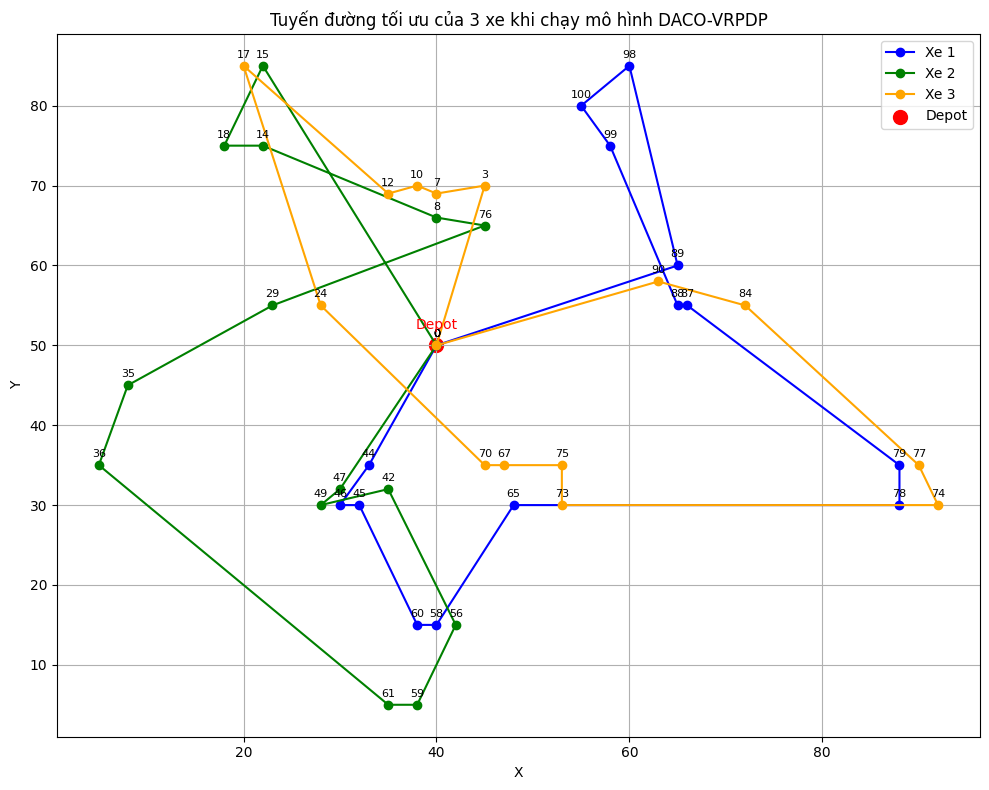

In [30]:
# Vẽ tuyến đường của mỗi xe

plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'purple', 'cyan']
for i, route in enumerate(best_solution):
    x_vals = [coords[n][0] for n in route]
    y_vals = [coords[n][1] for n in route]
    plt.plot(x_vals, y_vals, marker='o', label=f"Xe {i+1}", color=colors[i % len(colors)])
    for n in route:
        plt.text(coords[n][0], coords[n][1]+1, str(n), fontsize=8, ha='center')
plt.scatter(coords[0][0], coords[0][1], color='red', s=100, label='Depot')
plt.text(coords[0][0], coords[0][1]+2, 'Depot', color='red', fontsize=10, ha='center')
plt.title("Tuyến đường tối ưu của 3 xe khi chạy mô hình DACO-VRPDP")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## So sánh, đánh giá 4 mô hình ACO-VRPD(Base), HACO-VRPDP, IACO-VRPDP, DACO-VRPDP